In [1]:
import pandas as pd
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
from ast import literal_eval

/home/veton/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
lextreme_datasets = ['brazilian_court_decisions_judgment', 'brazilian_court_decisions_unanimity', 'swiss_judgment_prediction', 'german_argument_mining', 'greek_legal_code_volume', 'greek_legal_code_chapter', 'greek_legal_code_subject', 'online_terms_of_service_unfairness_levels', 'online_terms_of_service_clause_topics', 'covid19_emergency_event', 'multi_eurlex_level_1', 'lener_br', 'legalnero', 'greek_legal_ner', 'mapa_coarse', 'mapa_fine']

In [28]:
def split_into_languages(dataset):
    dataset_new = list()
    
    dataset_df = pd.DataFrame(dataset)
    
    for item in dataset_df.to_dict(orient='records'):
        labels = item['label']
        for language, document in literal_eval(item['input']).items():
            if document is not None:
                item_new = dict()
                item_new['language']=language
                item_new['input']=str(document)
                item_new['label']=labels
                dataset_new.append(item_new)
    
    dataset_new = pd.DataFrame(dataset_new)
    
    
    return  dataset_new


def create_histogram(dataset_name):
    dataset = load_dataset("joelito/lextreme",dataset_name)

    all_data_as_df = list()

    for split in ['train','validation','test']:
        df = pd.DataFrame(dataset[split])
        all_data_as_df.append(df)
        

    all_data_as_df = pd.concat(all_data_as_df)
    
    if dataset_name.startswith('multi_eurlex'):
        all_data_as_df = split_into_languages(all_data_as_df)
        
    try:
        all_data_as_df['input_split']=all_data_as_df.input.apply(lambda x:str(x).split())
    except:
        all_data_as_df['input_split']=all_data_as_df.input.apply(lambda x:len(x))
    all_data_as_df['input_split_length']=all_data_as_df.input_split.apply(lambda x:len(x))

    plt.figure(figsize=(20,10))
    ax = all_data_as_df.input_split_length.plot.hist(grid=True, bins=100)
    if dataset_name=='multi_eurlex_level_1':
        ax.set_xlim([0, 24700])
    elif dataset_name.startswith('greek_legal_code'):
        ax.set_xlim(0,16000)
        
        
    start, end = ax.get_xlim()
    
    ax.xaxis.set_ticks(np.arange(0, end, round(end/20,0)))
    plt.xlabel('Length of input', fontsize=16)
    plt.ylabel('Frequency of length value', fontsize=16)
    plt.title(dataset_name, fontsize=16)
    plt.savefig('../figures/histogram_'+'_'.join(dataset_name.split())+'.jpg')


  0%|          | 0/3 [00:00<?, ?it/s]

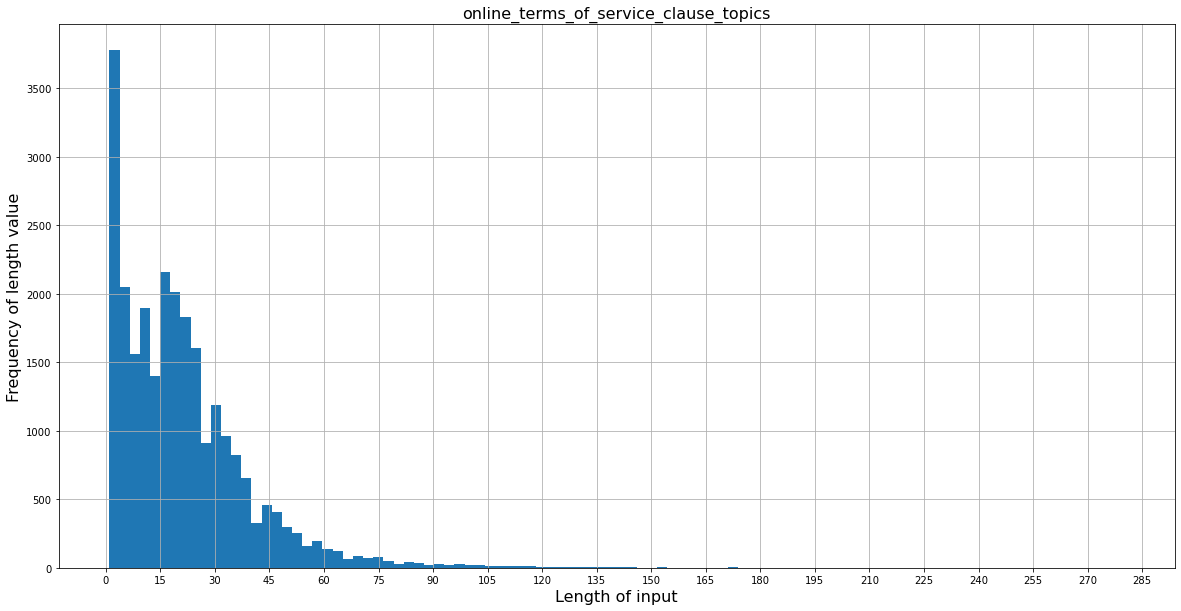

In [30]:
create_histogram('online_terms_of_service_clause_topics')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

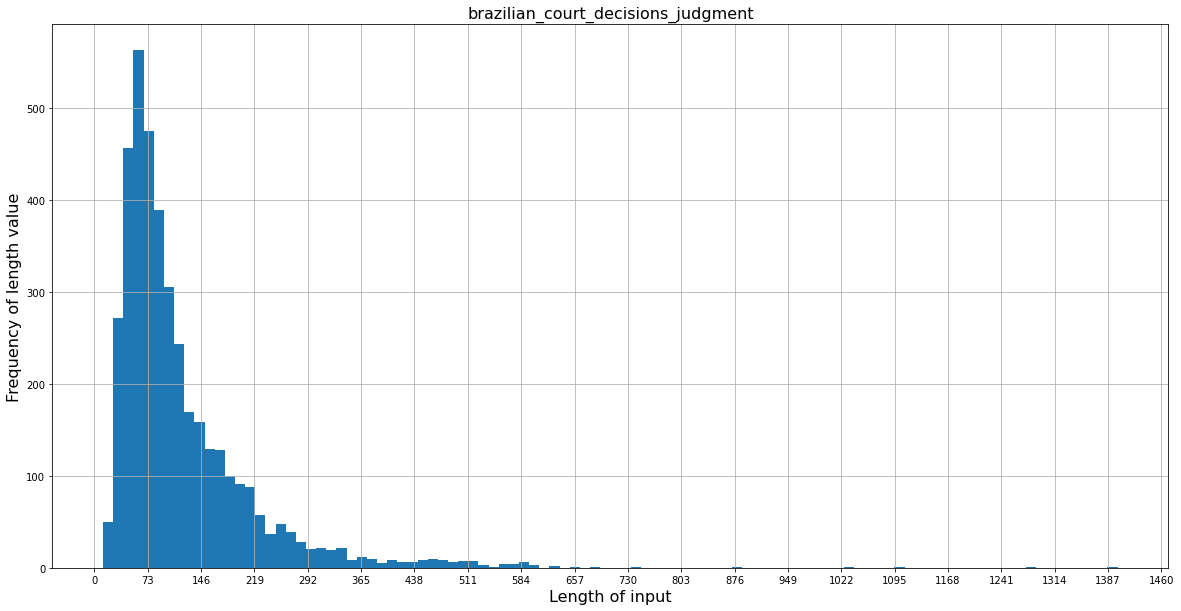

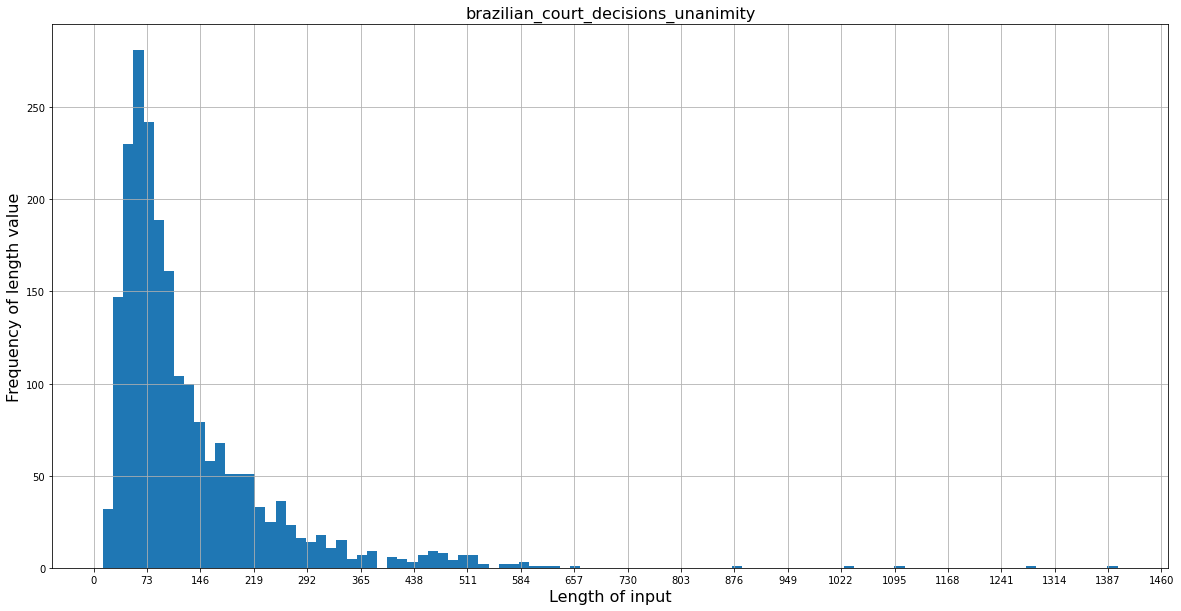

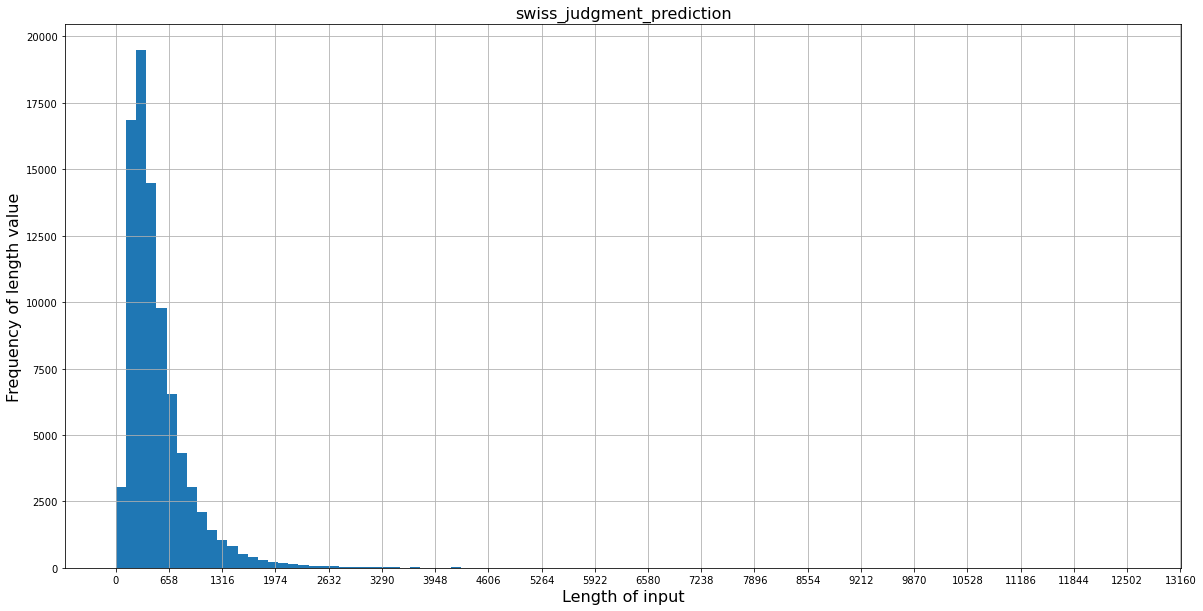

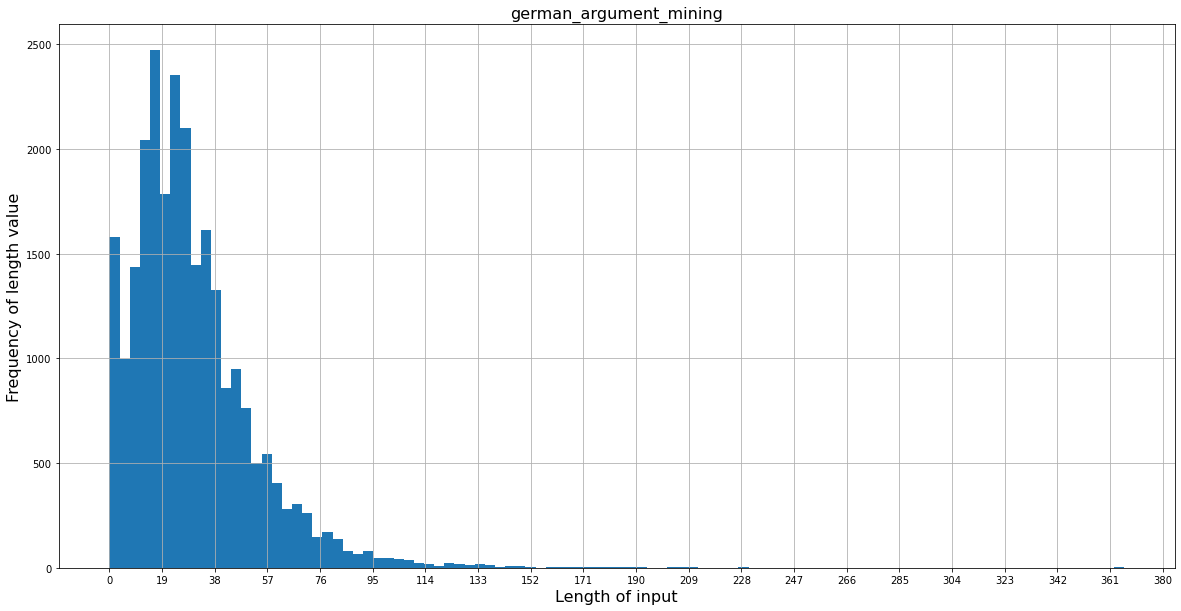

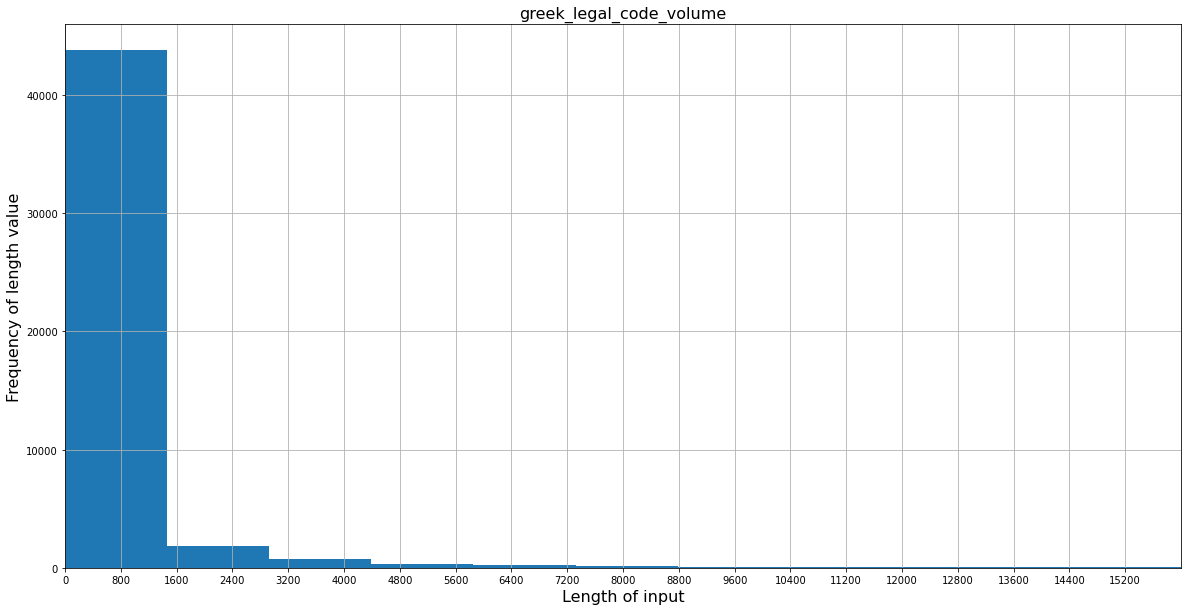

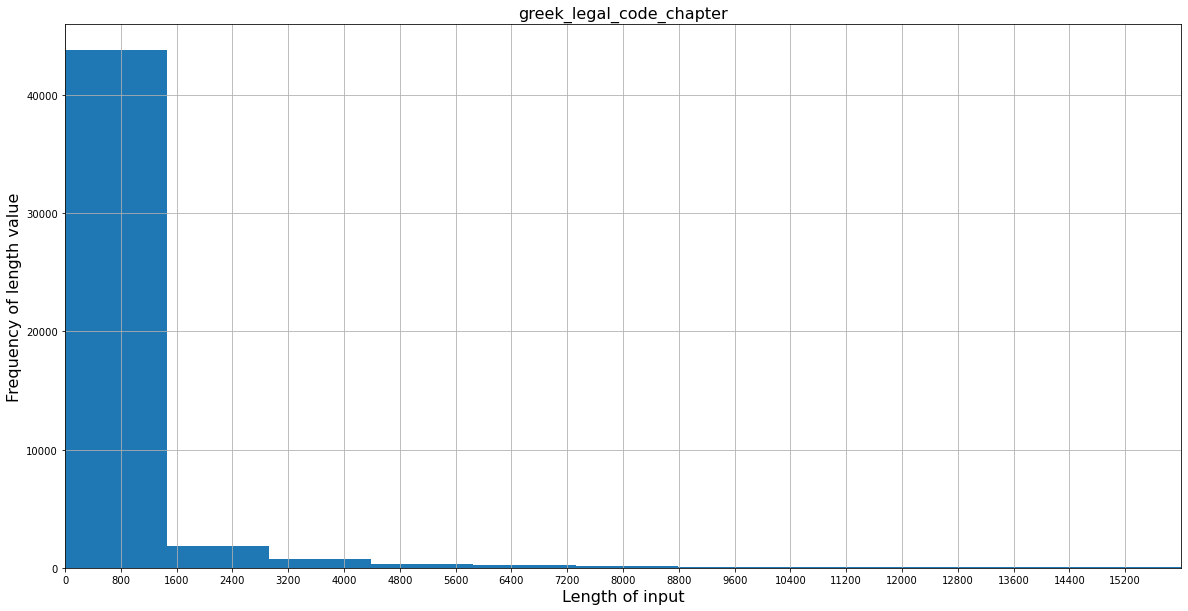

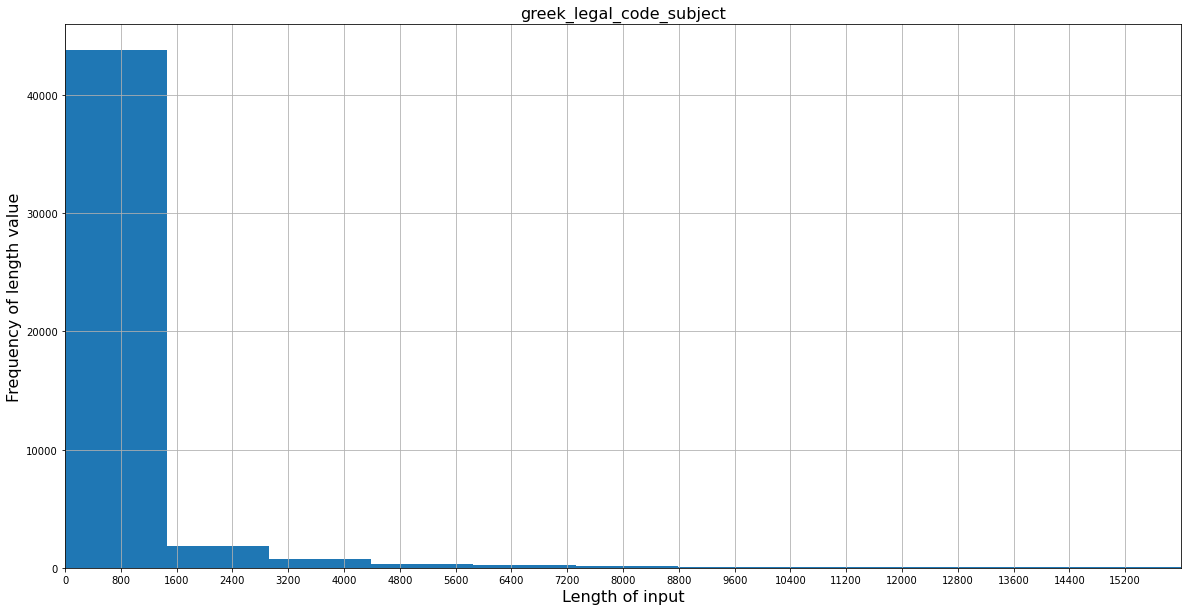

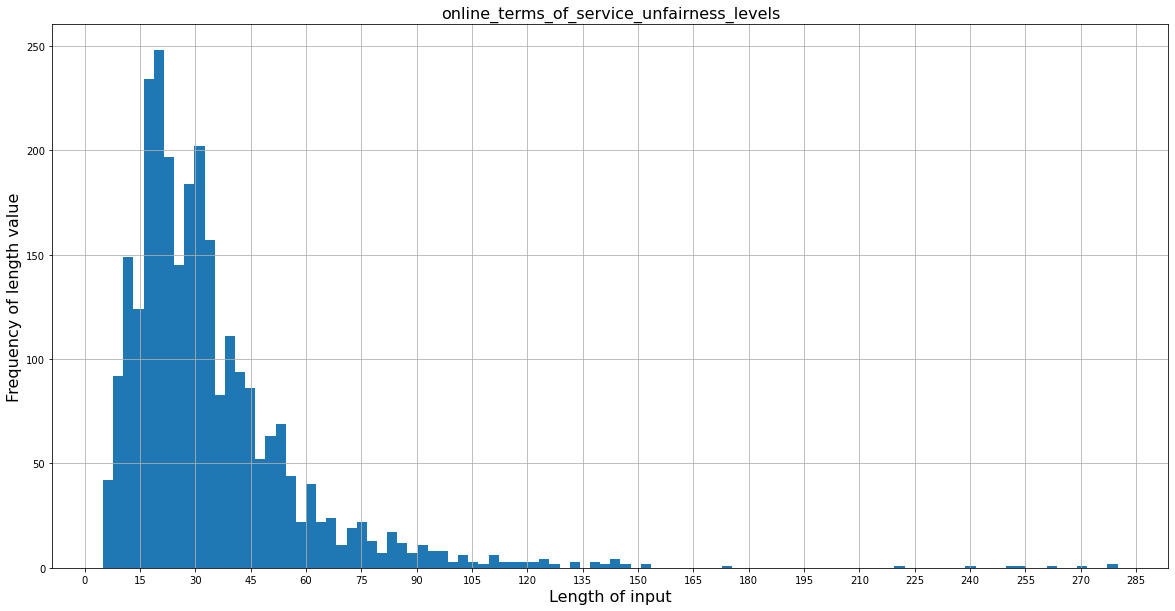

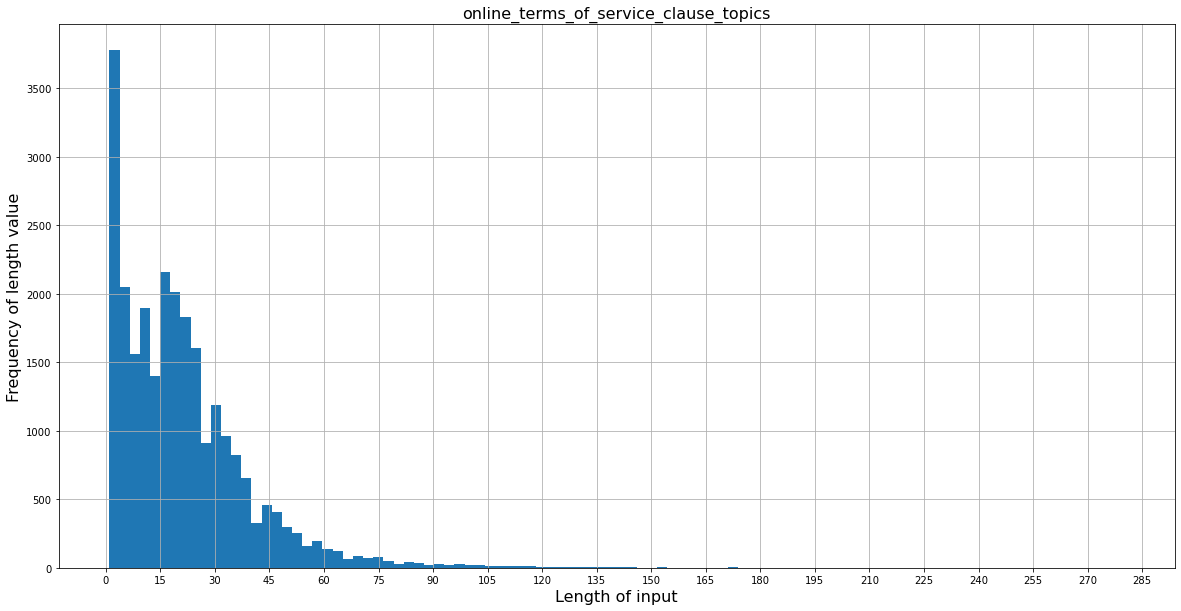

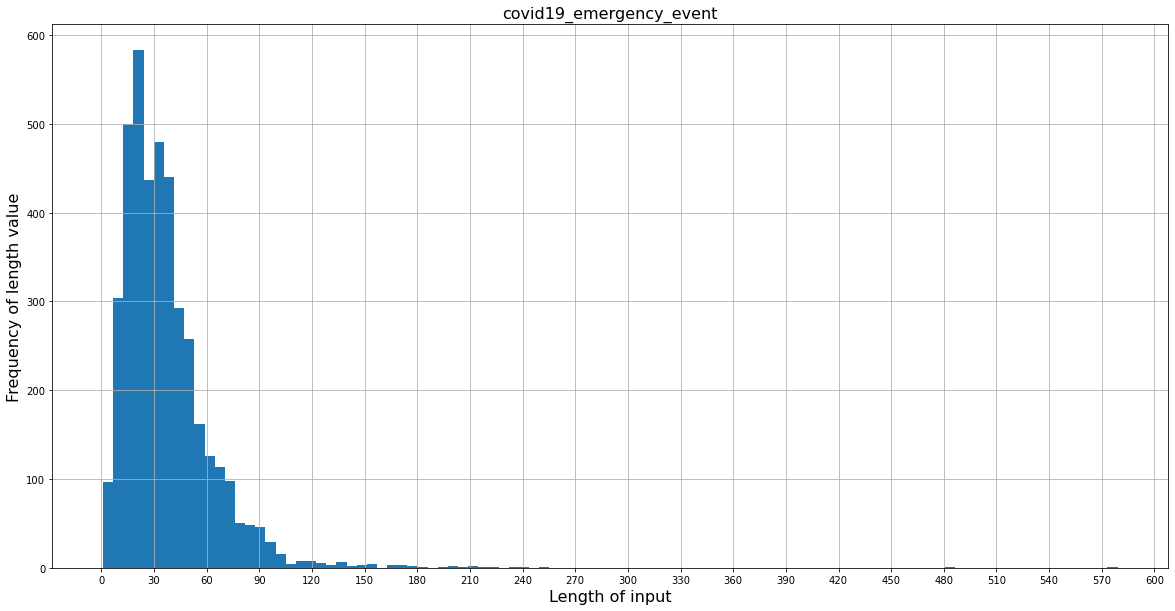

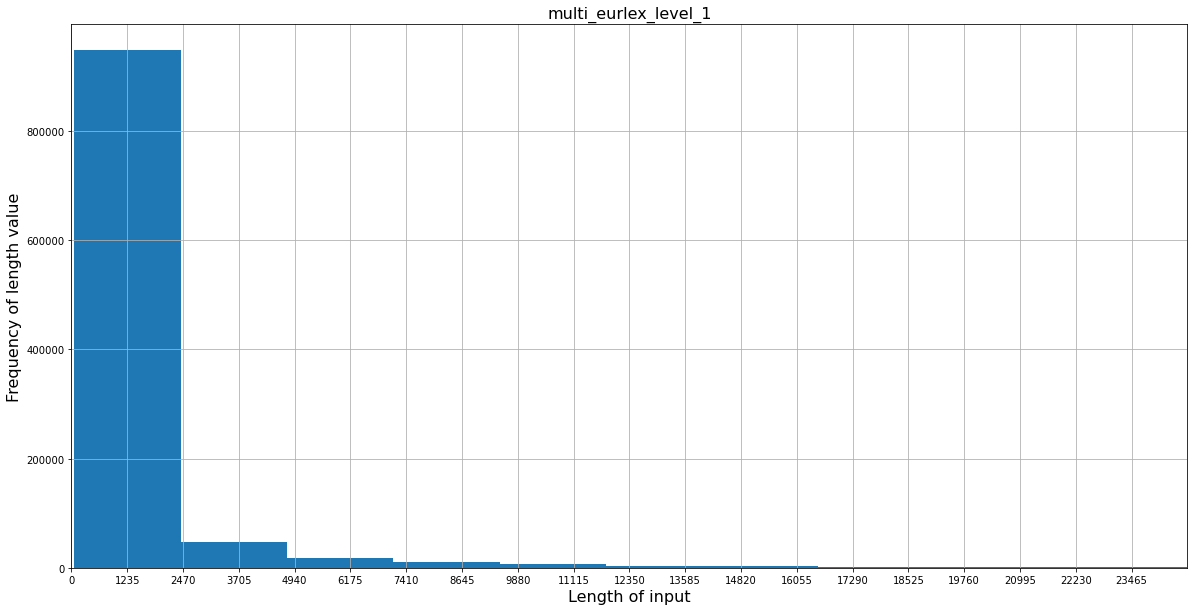

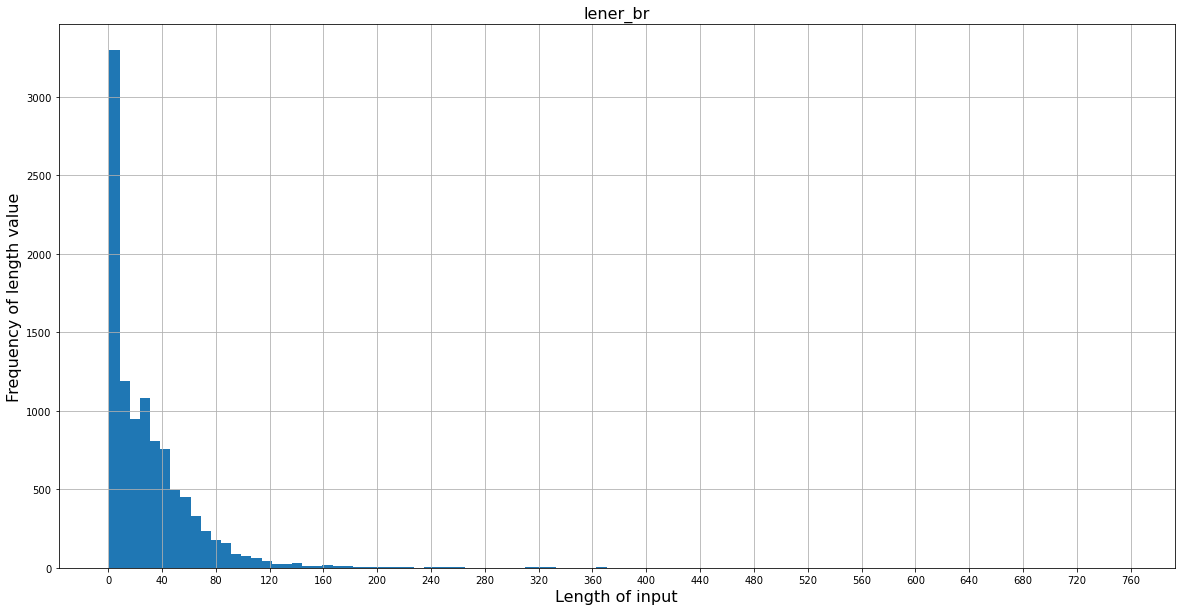

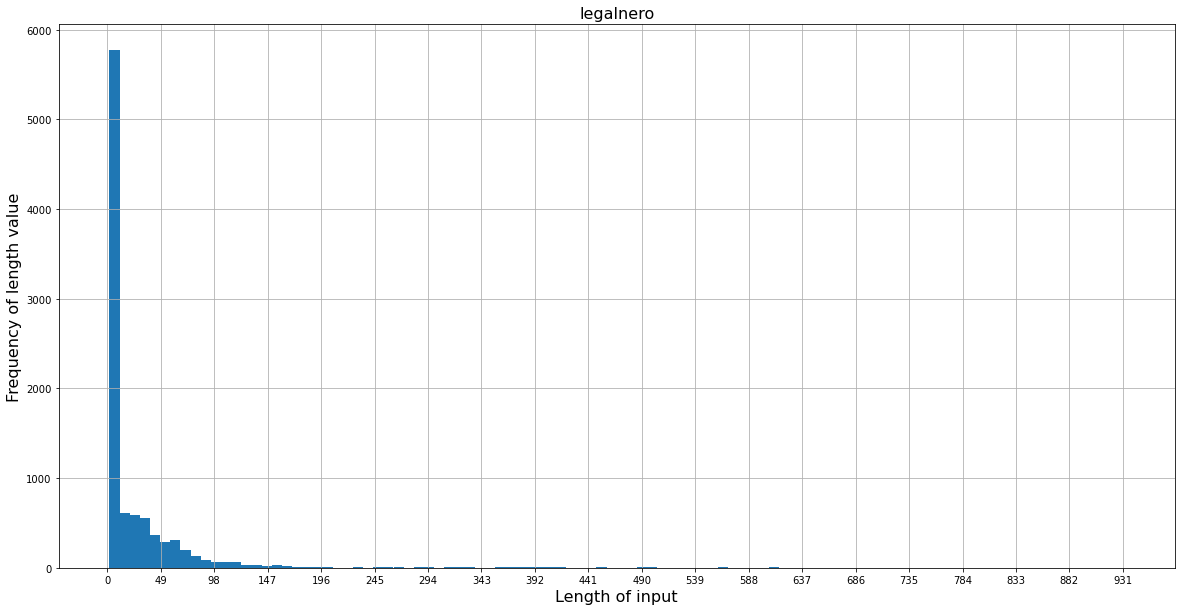

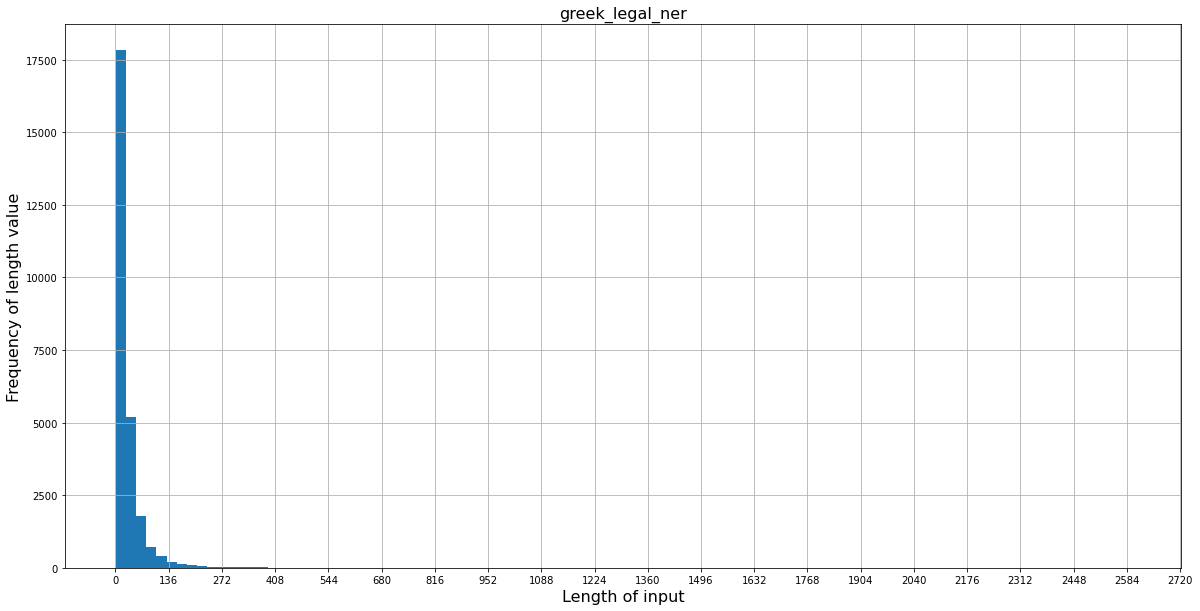

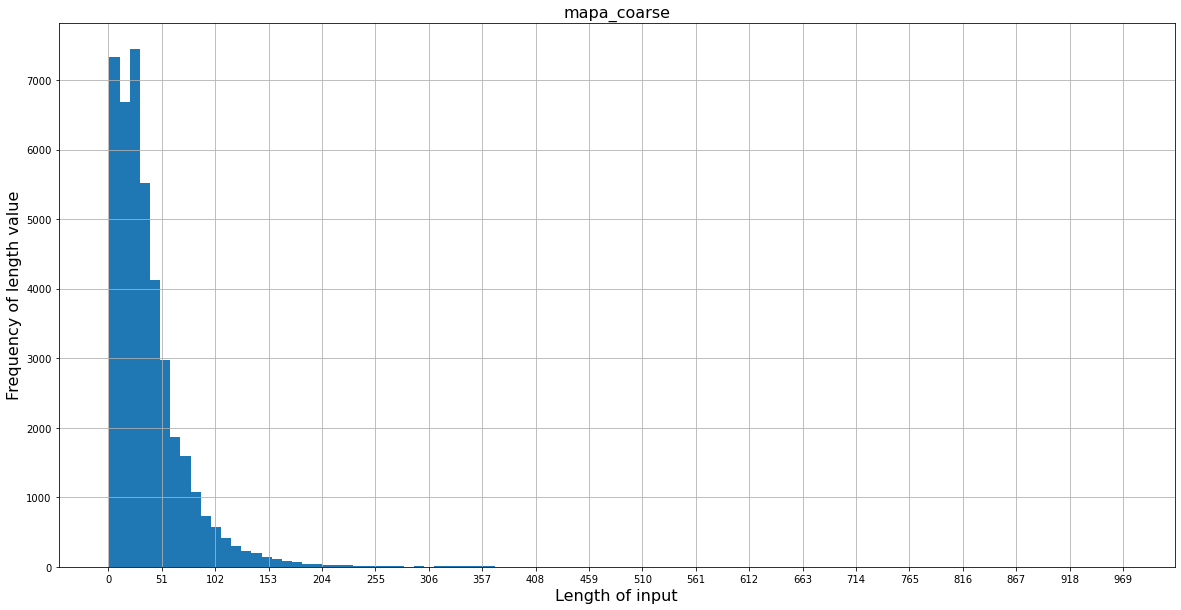

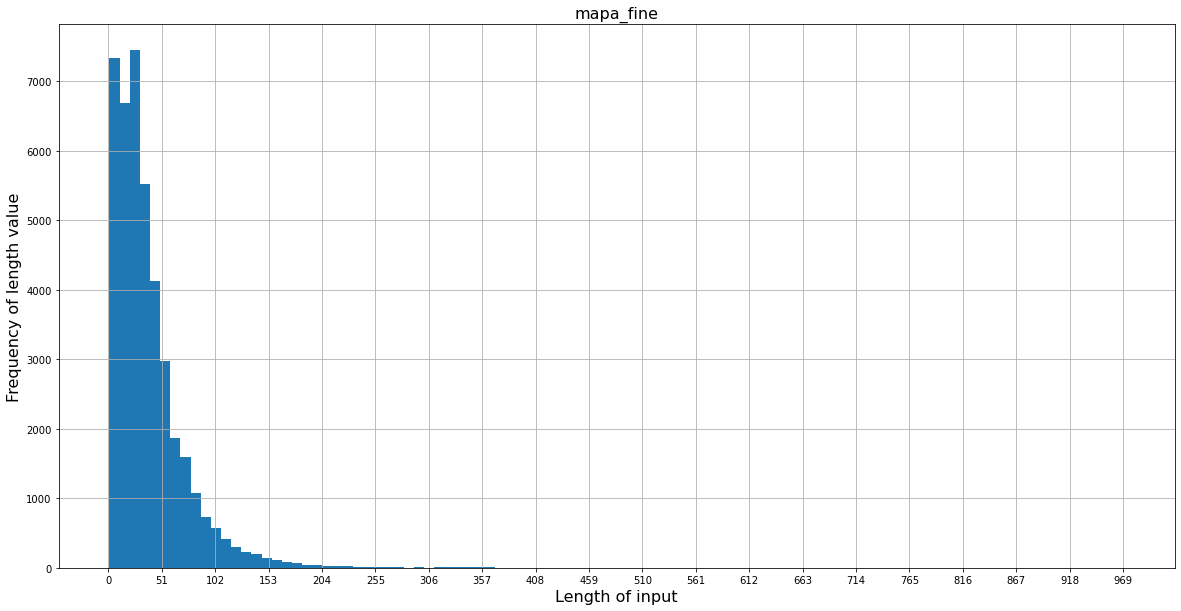

In [31]:
for ds in lextreme_datasets:
    create_histogram(ds)